In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Importing all necessary libraries ##

import numpy as np 
import os
import tensorflow as tf
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras import Sequential
from tensorflow.keras import layers

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.compat.v1.disable_eager_execution()

from keras.utils.np_utils import to_categorical
from keras import metrics
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.metrics import Recall
from keras.metrics import Precision
from tensorflow.keras.utils import plot_model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50


import cv2
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.utils import shuffle 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight


import math
import random


In [1]:
class_names = ["Batman", "Superman"]
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
num_classes = len(class_names)

## Test to check that our classes are correct for classifcation:
print(num_classes)
print(class_names)

IMAGE_SIZE = (150,150)

2
['Batman', 'Superman']


In [ ]:
## Function to load data, retrieved from https://www.kaggle.com/vincee/intel-image-classification-cnn-keras 
def load_data():
    
    #datasets = ["C:/Users/dodi/Desktop/NEURAL PROJECT/TRAIN_DATA150x150" , "C:/Users/dodi/Desktop/NEURAL PROJECT/TEST_DATA150x150"]
    datasets = ["/content/drive/MyDrive/Neural Project/TRAIN_DATA150x150" , "/content/drive/MyDrive/Neural Project/TEST_DATA150x150"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image # : '.format(index) + class_names[labels[index]])
    plt.show()

  
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [ ]:
## Generating the actual and predicted data based on our model
## As used in lecture

def generate_actual_predicted(model, X_test, Y_test):
    # Get the predictions
    Y_pred = model.predict(X_test)

    # Create a list of predictions

    #Converting predictions to label
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))

    #Converting one hot encoded test label back to label
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))

    return actual, predicted

In [ ]:
## Creating a recall, precision and f1-score function in case of the functions not operating
## We did this in case we used sparse_categorical_crossentropy as the model loss function, 
## but we ended up not doing so, so this piece of code is redundant. 

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [ ]:
(train_images, train_labels), (test_images, test_labels)  = load_data() ## To load the data in, function was retreived online 
print("Done")

  9%|▊         | 36/422 [00:00<00:01, 352.46it/s]

Loading /content/drive/MyDrive/Neural Project/TRAIN_DATA150x150


  0%|          | 0/103 [00:00<?, ?it/s]

Loading /content/drive/MyDrive/Neural Project/TEST_DATA150x150


100%|██████████| 69/69 [00:00<00:00, 402.75it/s]


Done


In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 4715
Number of testing examples: 1174
Each image is of size: (150, 150)


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25) ## Setting the data and its label to a random state through shuffle

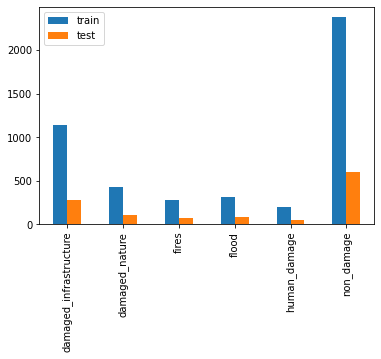

In [ ]:
## This program allows us to visualize the data to perform calculations to balance the data

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

In [ ]:
## Data calculations to help with balance
total_damage = 0

print("Classes 0 through 4: ")
for i in range(len(train_counts)-1):
    total_damage += train_counts[i]
    print(train_counts[i])

print("------------")
print("Sum classes 0 through 4: ")
print(total_damage)
print("------------")

total_non_damage = train_counts[-1]
print("Class 5: ")
print(total_non_damage)

r_05 = train_counts[0] / train_counts[5] * 100
r_15 = train_counts[1] / train_counts[5] * 100
r_25 = train_counts[2] / train_counts[5] * 100
r_35 = train_counts[3] / train_counts[5] * 100
r_45 = train_counts[4] / train_counts[5] * 100

print("Ratio of class 0 to class 5: ", r_05)
print("Ratio of class 1 to class 5: ", r_15)
print("Ratio of class 2 to class 5: ", r_25)
print("Ratio of class 3 to class 5: ", r_35)
print("Ratio of class 4 to class 5: ", r_45)

Classes 0 through 4: 
1135
422
280
308
192
------------
Sum classes 0 through 4: 
2337
------------
Class 5: 
2378
Ratio of class 0 to class 5:  47.72918418839361
Ratio of class 1 to class 5:  17.74600504625736
Ratio of class 2 to class 5:  11.774600504625736
Ratio of class 3 to class 5:  12.95206055508831
Ratio of class 4 to class 5:  8.074011774600505


In [ ]:
## Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

batch_size=128
width = 150

In [ ]:
print(train_labels)
print(class_names_label)

[1 0 5 ... 5 5 1]
{'damaged_infrastructure': 0, 'damaged_nature': 1, 'fires': 2, 'flood': 3, 'human_damage': 4, 'non_damage': 5}


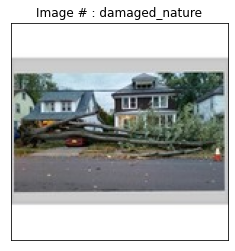

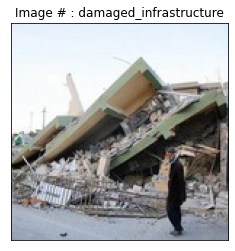

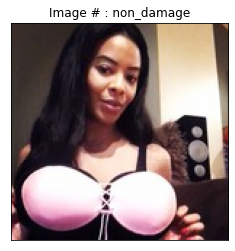

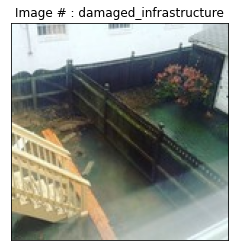

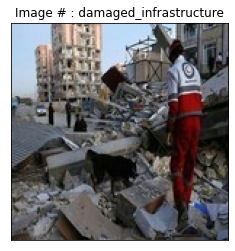

In [ ]:
## Display 5 random images from the datasets to ensure that everything is working correctly. 
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)
display_random_image(class_names, train_images, train_labels)

In [ ]:
#class_weight = {0: r_05,
#                1: r_15,
#                2: r_25,
#                3: r_35,
#                4: r_45,
#                5: 1.,
#               }


## This piece of code runs to give us the balanced computed class weights but has been commented out since it
## does not work with the model type that we are using. However, the actual weights were copied and placed into
## another dictionary that is shown below. 


#class_weights = class_weight.compute_class_weight('balanced',
#                                                np.unique(np.array(train_labels)),
#                                                 np.array(train_labels))
#
#print(class_weights)


class_weights = {0:0.69236417, 1:1.8621643  , 2:2.80654762 , 3:2.55140693 , 4:4.09288194  , 5:0.33045977 }
print(class_weights)


{0: 0.69236417, 1: 1.8621643, 2: 2.80654762, 3: 2.55140693, 4: 4.09288194, 5: 0.33045977}


In [ ]:
## One hot-encoding the data
train_labels = to_categorical(train_labels) 
test_labels = to_categorical(test_labels)

In [ ]:
#print(train_labels)


## Printing labels (Y) to ensure that everything is working properly
print(train_labels)
print(train_labels.shape)
print(test_labels)
print(test_labels.shape)


#train_labels = np.argmax(train_labels, axis = 1)
#print(train_labels)
#test_labels = np.argmax(test_labels, axis = 1)
#print(test_labels)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]
(4715, 6)
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(1174, 6)


In [ ]:
## Various models are included here. We can uncomment to use one model but everything was done in this. 

#------------------------------#

#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
  
#    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
#    tf.keras.layers.MaxPooling2D(2,2),
   
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(units = 512, activation = 'relu'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(units = 128, activation = 'relu'),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(units = 6, activation = 'softmax'),
#]) 


#------------------------------#
#model = tf.keras.Sequential([
#    
#    
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
    

#    tf.keras.layers.Dropout(0.4),
   
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])

#------------------------------# This one is decent but not the best
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])
#------------------------------#
#------------------------------#
#------------------------------#
#------------------------------# BEST SO FAR
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    #tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    #tf.keras.layers.MaxPooling2D(2,2),

#    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
#])

#------------------------------# BEST SO FAR
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
#    tf.keras.layers.ZeroPadding2D( padding = 1 ),
#    tf.keras.layers.MaxPooling2D(2,2),
#    #tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    #tf.keras.layers.MaxPooling2D(2,2),

    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    #tf.keras.layers.Dense(512, activation=tf.nn.relu),
#    #tf.keras.layers.Dense(1024, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
#])


#------------------------------#
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    #tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    #tf.keras.layers.MaxPooling2D(2,2),

#    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.6),
#   tf.keras.layers.Dense(6, activation=tf.nn.softmax),
#])
#------------------------------# 


#------------------------------#
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),

#    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    #tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),


#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),


#    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Dropout(0.3),
#    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
#    #tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
    
#    tf.keras.layers.ZeroPadding2D( padding = (1,1)),
#    tf.keras.layers.MaxPooling2D(2,2),


#    tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
#    #tf.keras.layers.MaxPooling2D(2,2),

#    #model.add(layers.ZeroPadding2D( padding = 1 )),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dropout(0.6),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax),
#])
#------------------------------# 

#model = ResNet50(weights='imagenet', include_top=False)
#train_features = model.predict(train_images)
#test_features = model.predict(test_images)


#------------------------------#
#model = VGG16(weights = 'imagenet', include_top = False, input_shape= (150,150, 3), classes = 6, classifier_activation="softmax")
#------------------------------#


#------------------------------#

#model = tf.keras.Sequential()
#model.add(Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Flatten())
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=4096,activation="relu"))
#model.add(Dense(units=6, activation="softmax")) 



#------------------------------#


#model = tf.keras.Sequential()

#model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
#model.add(layers.ZeroPadding2D( padding = 1 ))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

#model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
#model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
#model.add(layers.ZeroPadding2D( padding = 1 ))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.25))

#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation=tf.nn.relu))

#model.add(layers.Dropout(0.5))

#model.add(layers.Dense(6, activation=tf.nn.softmax))



#model = VGG16(weights='imagenet', include_top=False)

#train_features = model.predict(train_images)
#test_features = model.predict(test_images)
#model = tf.keras.Sequential([
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(50, activation=tf.nn.relu),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])



#------------------------------#

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 512)       1

In [ ]:
## Compiling: 

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',
                        metrics.AUC(name='auc'),
                        metrics.Precision(name='precision'),
                        metrics.Recall(name='recall'),
                        ])


#model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
## Training...
num_epochs = 40 ## We used 40 epochs as we found it better than using 20. 
history = model.fit(train_images, train_labels, batch_size=128, epochs= num_epochs, validation_split = 0.25,class_weight=class_weights)

Train on 3536 samples, validate on 1179 samples
Epoch 1/40
3536/3536 [==============================] - ETA: 0s - loss: 1.7857 - accuracy: 0.1714 - auc: 0.5576 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3536/3536 [==============================] - 9s 2ms/sample - loss: 1.7857 - accuracy: 0.1714 - auc: 0.5576 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8097 - val_accuracy: 0.3104 - val_auc: 0.6884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
3536/3536 [==============================] - 5s 2ms/sample - loss: 1.6711 - accuracy: 0.2192 - auc: 0.6800 - precision: 0.3105 - recall: 0.0192 - val_loss: 1.7989 - val_accuracy: 0.1442 - val_auc: 0.5567 - val_precision: 0.7143 - val_recall: 0.0042
Epoch 3/40
3536/3536 [==============================] - 5s 2ms/sample - loss: 1.6255 - accuracy: 0.1394 - auc: 0.6112 - precision: 0.3592 - recall: 0.0249 - val_loss: 1.6936 - val_accuracy: 0.2901 - val_auc: 0.7004 - val_precision: 0.2903 - val_recall: 0.0305
Epoch 4/40
3536/3536 [==============================] - 5s 2ms/sample - loss: 1.6003 - accuracy: 0.1844 - auc: 0.6652 - precision: 0.3359 - recall: 0.0243 - val_loss: 1.7110 - val_accuracy: 0.2053 - val_auc: 0.6773 

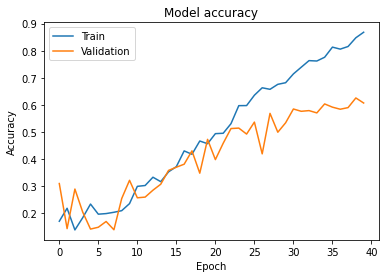

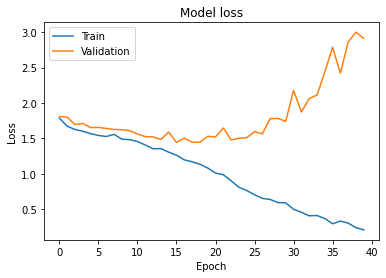

In [ ]:
## Retrieved from lecture notes

## Plotting the accuracy over time. 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the loss over time
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

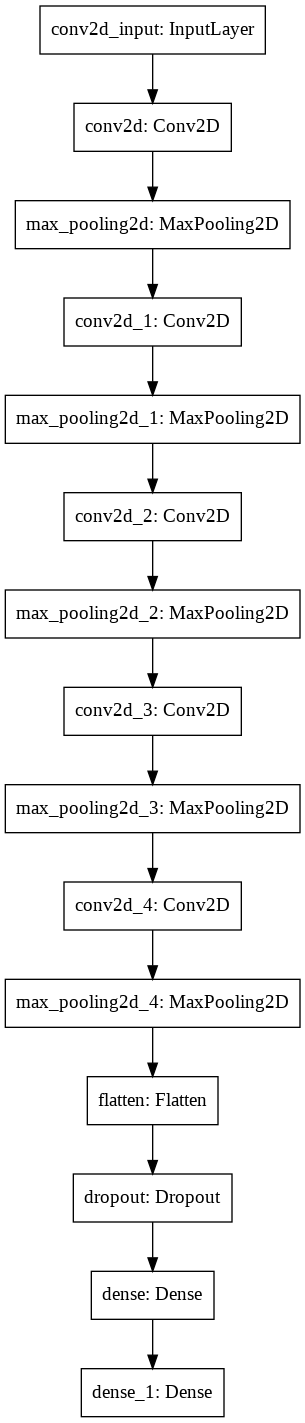

In [ ]:
## Plotting the actual model itself
plot_model(model)

In [ ]:
print("Number of images in our test_data: ")
print(test_labels.shape[0])
print(test_images.shape[0])
#train_labels = np.argmax(train_labels, axis = 1)
print(train_labels)
#test_labels = np.argmax(test_labels, axis = 1)
print(test_labels)

Number of images in our test_data: 
1174
1174
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [ ]:
#test_labels = to_categorical(test_labels)
#print(test_labels)


## To test the model with the testing_data

score = model.evaluate(test_images, test_labels)
#score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Test loss: 1.6395984881984313
Test accuracy: 0.6158433


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


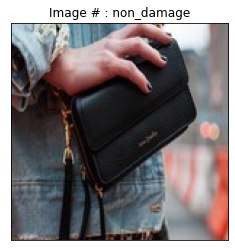

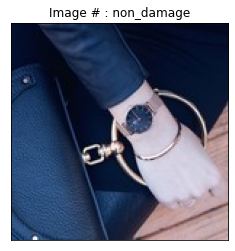

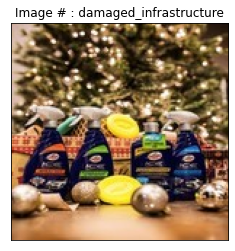

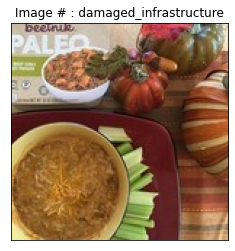

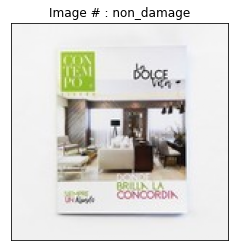

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
actual, predicted = generate_actual_predicted(model, test_images, test_labels)


## Predicting 5 random images:

display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)
display_random_image(class_names, test_images, pred_labels)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


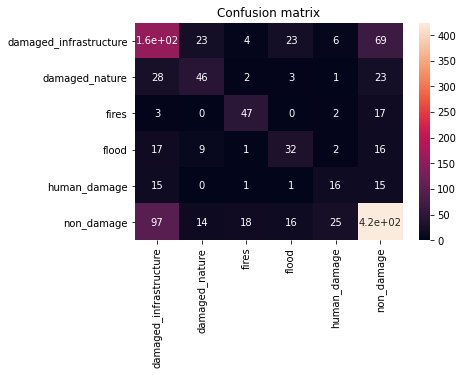

In [ ]:
## Confusion matrix (Code found online, https://www.kaggle.com/vincee/intel-image-classification-cnn-keras)

print(train_labels)
train_labels = np.argmax(train_labels, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sb.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

,AUC
0,0.779967
1,0.807430
2,0.922972
3,0.835739
4,0.818384
5,0.803524


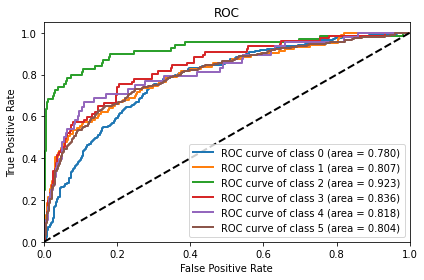

In [ ]:
## Printing ROC curve, retrieved code from lecture notes

y = to_categorical(test_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.shape[1]  

# compare each class's probabilities one by one
# each acts like a single column
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print the AUC scores
from IPython.display import display
import pandas as pd
auc_array = np.array(list(roc_auc.items()))
df = pd.DataFrame(auc_array[:,1])
df.columns = ['AUC']
display(df)

# Draw the pairwise ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.3f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC.png')
plt.show()

In [ ]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53       283
           1       0.50      0.45      0.47       103
           2       0.64      0.68      0.66        69
           3       0.43      0.42      0.42        77
           4       0.31      0.33      0.32        48
           5       0.75      0.71      0.73       594

    accuracy                           0.62      1174
   macro avg       0.52      0.52      0.52      1174
weighted avg       0.62      0.62      0.62      1174



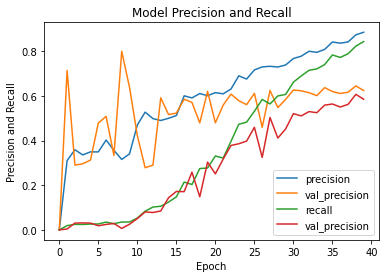

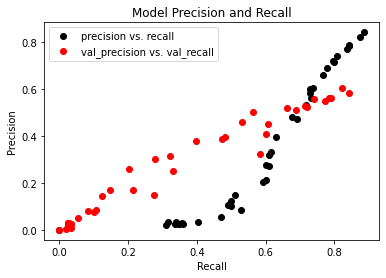

In [ ]:
plt.plot(history.history['precision'],label='precision')
plt.plot(history.history['val_precision'],label='val_precision')
plt.plot(history.history['recall'],label='recall')
plt.plot(history.history['val_recall'],label='val_precision')
plt.title('Model Precision and Recall')
plt.ylabel('Precision and Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validate'], loc='upper left')
#plt.show()

#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validate'], loc='upper left')
#plt.show()


plt.plot(history.history['precision'],history.history['recall'],'o', color='black',label='precision vs. recall')
plt.plot(history.history['recall'],history.history['val_recall'],'o', color='red',label='val_precision vs. val_recall')
plt.title('Model Precision and Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

In [ ]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])


  model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy',
                        metrics.AUC(name='auc'),
                        metrics.Precision(name='precision'),
                        metrics.Recall(name='recall'),
                        ])
  return model

#  model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
#])


    
    
    
    
    
    
 # return model

In [ ]:
print(train_labels)
train_labels = to_categorical(train_labels)
print(train_labels)
print(train_labels.shape)

[1 0 5 ... 5 5 1]
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]
(4715, 6)


In [ ]:
n_split=10
#zero_division = 0

 
# We will split the the data n_split times
# and create and for the model with the said
# parameters


results = list()
for train_index,test_index in KFold(n_split).split(train_images): 
  print(train_index + 1)
  # use the index to generate training an testing sets
  x_train,x_test=train_images[train_index],train_images[test_index]
  y_train,y_test=train_labels[train_index],train_labels[test_index]
  
  # create and fit the model
  model=create_model()
  #model.fit(x_train, y_train,epochs=2)
  model.fit(x_train, y_train, epochs= 40, class_weight=class_weights)
  
  # print and show generic metrics available
  scores = model.evaluate(x_test,y_test)
 
  # print the model metrics
  for i,names in zip(np.arange(0,len(model.metrics_names)),model.metrics_names):
      print(model.metrics_names[i],'=',scores[i])
  # calculate and print more metrics
  actual, predicted = generate_actual_predicted(model, x_test, y_test)
  print("precision ",precision_score(actual, predicted, average='macro'))
  print("recall ", recall_score(actual, predicted, average='macro'))
  print("F1-Score ", f1_score(actual, predicted, average='macro'))
  results.append([precision_score(actual, predicted, average='macro'),
                  recall_score(actual, predicted, average='macro'), 
                  f1_score(actual, predicted, average='macro') ])

[ 473  474  475 ... 4713 4714 4715]
Train on 4243 samples
Epoch 1/40
4243/4243 [==============================] - 2s 573us/sample - loss: 1.7915 - accuracy: 0.2232 - auc: 0.6198 - precision: 0.3525 - recall: 0.0203
Epoch 2/40
4243/4243 [==============================] - 2s 532us/sample - loss: 1.5264 - accuracy: 0.2953 - auc: 0.7174 - precision: 0.4579 - recall: 0.0474
Epoch 3/40
4243/4243 [==============================] - 2s 535us/sample - loss: 1.3037 - accuracy: 0.4235 - auc: 0.7892 - precision: 0.5743 - recall: 0.1612
Epoch 4/40
4243/4243 [==============================] - 2s 534us/sample - loss: 0.9481 - accuracy: 0.5781 - auc: 0.8761 - precision: 0.7081 - recall: 0.3853
Epoch 5/40
4243/4243 [==============================] - 2s 537us/sample - loss: 0.6098 - accuracy: 0.6880 - auc: 0.9298 - precision: 0.7722 - recall: 0.5751
Epoch 6/40
4243/4243 [==============================] - 2s 540us/sample - loss: 0.3701 - accuracy: 0.8030 - auc: 0.9690 - precision: 0.8557 - recall: 0.7521


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


loss = 4.080245381694729
accuracy = 0.51059324
auc = 0.7636922
precision = 0.51391864
recall = 0.5084746
precision  0.404403136697187
recall  0.3547422196017442
F1-Score  0.3710213449391225
[   1    2    3 ... 4713 4714 4715]
Train on 4243 samples
Epoch 1/40
4243/4243 [==============================] - 2s 550us/sample - loss: 1.7801 - accuracy: 0.2715 - auc: 0.6852 - precision: 0.3561 - recall: 0.0283
Epoch 2/40
4243/4243 [==============================] - 2s 536us/sample - loss: 1.5702 - accuracy: 0.2694 - auc: 0.6955 - precision: 0.4578 - recall: 0.0486
Epoch 3/40
4243/4243 [==============================] - 2s 536us/sample - loss: 1.3139 - accuracy: 0.4051 - auc: 0.7817 - precision: 0.5836 - recall: 0.1513
Epoch 4/40
4243/4243 [==============================] - 2s 538us/sample - loss: 0.8288 - accuracy: 0.5953 - auc: 0.8886 - precision: 0.7307 - recall: 0.4157
Epoch 5/40
4243/4243 [==============================] - 2s 538us/sample - loss: 0.4261 - accuracy: 0.7568 - auc: 0.9581 - pr

[0.40440314 0.40034113 0.43850878 0.37628388 0.4015994  0.38075802
 0.37322983 0.38578715 0.36055535 0.50410349]
[0.35474222 0.38287143 0.37175961 0.34835749 0.35465585 0.33844775
 0.35997941 0.3080434  0.33137006 0.39976067]


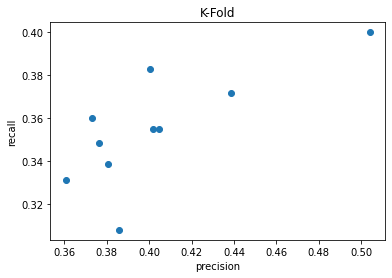

min precision: 0.3605553549605
min recall: 0.3080433962712695
max precision: 0.5041034857320855
max recall: 0.39976066947327077
average precision: 0.4025570177975137 sd= 0.039603504596090466
average recall: 0.3549987881813988 sd= 0.02483464312641307


In [ ]:
# Plot the curves for precision
res = np.array(results)
#print(res)

prec = res[:,0]
print(prec)
recl = res[:,1]
print(recl)

import matplotlib.pyplot as plt
plt.scatter(prec, recl)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('K-Fold') 
plt.show()

print('min precision:', prec.min())
print('min recall:', recl.min())
print('max precision:', prec.max())
print('max recall:', recl.max())
print('average precision:', prec.mean(), 'sd=', prec.std())
print('average recall:', recl.mean(),'sd=', recl.std())

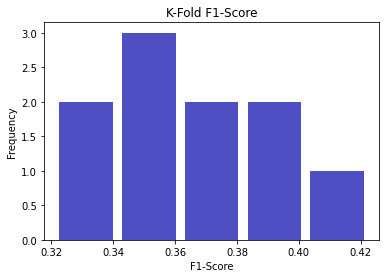

F1-Score: 0.36682530287206955 sd= 0.027363677186799877


In [ ]:
# show f1-score for k-fold
res = np.array(results)
f1_score = res[:,2]
plt.hist(x=f1_score, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title('K-Fold F1-Score') 
plt.ylabel('Frequency') 
plt.xlabel('F1-Score') 
plt.show()
print('F1-Score:', f1_score.mean(), 'sd=', f1_score.std())

res_model1 = res


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 41472)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               5308544   
_________________________________________________________________
dense_21 (Dense)             (None, 6)               